# Initialize the accelerator

### Remember to install the following dependencies:

In [1]:
! pip install brevitas


[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from finn_examples import models
print(list(filter(lambda x: "super_res" in x, dir(models))))

['_espcn_super_res_io_shape_dict', 'espcn_w4a4_super_res']


In [3]:
accel = models.espcn_w4a4_super_res()

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 214.28357MHz.
  warnings.warn(


In [4]:
print(f"Expected input shape: {accel.ishape_normal()}")
print(f"Expected input datatype: {accel.idt()}\n")
print(f"Expected output shape: {accel.oshape_normal()}")
print(f"Expected output datatype: {accel.odt()}")

Expected input shape: (1, 128, 128, 3)
Expected input datatype: UINT8

Expected output shape: (1, 256, 256, 3)
Expected output datatype: UINT8


# Load example image

Image shape: (256, 256, 3)


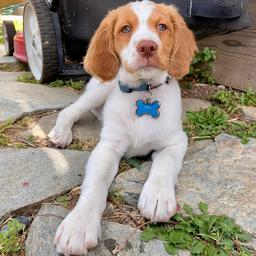

In [5]:
import numpy as np
from PIL import Image

hr_image_golden = Image.open("images/finn.jpg")
hr_image_shape = (*hr_image_golden.size, 3)
print(f"Image shape: {hr_image_shape}")
hr_image_golden

Downscale the example image

Image shape: (128, 128, 3)


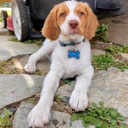

In [6]:
lr_image = hr_image_golden.resize((128,128))
lr_image_shape = (*lr_image.size, 3)
print(f"Image shape: {lr_image_shape}")
lr_image

# Upsample the single image

In [7]:
# NOTE: Need to first cast the image as a numpy array and expand for batch-1 inference
inp = np.array(lr_image)
inp = np.expand_dims(inp, 0)
out = accel.execute([inp])
print(f"Input shape: {inp.shape}")
print(f"output shape: {out.shape}")

Input shape: (1, 128, 128, 3)
output shape: (1, 256, 256, 3)


Image shape: (256, 256)


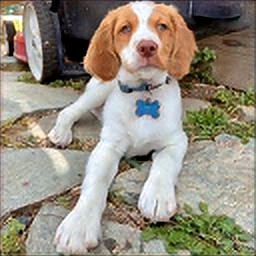

In [8]:
# NOTE: Need to cast as unsigned 8-bit integers to properly display
hr_image = np.asarray(out[0], dtype=np.uint8)
hr_image = Image.fromarray(hr_image)
print(f"Image shape: {hr_image.size}")
hr_image

# Validation PSNR on BSD300 dataset

In [9]:
import brevitas_examples.super_resolution.utils as utils

In [10]:
_, testloader = utils.get_bsd300_dataloaders(
    data_root="data",
    crop_size=256,
    upscale_factor=2,
    download=True,
    batch_size_test=1
)

In [11]:
def calc_psnr(ref_image: np.ndarray, gen_image: np.ndarray, eps: float = 1e-10) -> float:
    x = ref_image.astype(np.float32)
    y = gen_image.astype(np.float32)
    dist = np.square(x - y).mean()
    psnr = 10. * np.log10(pow(255, 2) / max(dist, eps))
    return psnr

In [12]:
total_psnr = 0.
for inp, target in testloader:
    target = np.moveaxis(target.numpy() * 255., 1, 3)
    inp = np.moveaxis(inp.numpy() * 255., 1, 3)
    inp = np.asarray(inp, dtype=np.uint8)
    out = accel.execute([inp])
    out = np.asarray(out)
    psnr = calc_psnr(target, out)
    total_psnr += psnr
avg_psnr = total_psnr / len(testloader)
print(f"PSNR: {avg_psnr:.2f} dB")

PSNR: 26.54 dB


# More benchmarking

In [13]:
%%timeit
out = accel.execute([inp])

26 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
batch_size = 100
accel.batch_size = batch_size
accel.throughput_test()

{'runtime[ms]': 2209.373950958252,
 'throughput[images/s]': 45.26169051492071,
 'DRAM_in_bandwidth[MB/s]': 2.2247026121893825,
 'DRAM_out_bandwidth[MB/s]': 8.89881044875753,
 'fclk[mhz]': 214.283571,
 'batch_size': 100,
 'fold_input[ms]': 0.10824203491210938,
 'pack_input[ms]': 0.07510185241699219,
 'copy_input_data_to_device[ms]': 6.415367126464844,
 'copy_output_data_from_device[ms]': 22.461891174316406,
 'unpack_output[ms]': 49.977779388427734,
 'unfold_output[ms]': 0.148773193359375}